In [70]:
import pandas as pd
import sh
from collections import Counter
from nltk import word_tokenize
from string import punctuation
from pycountry import languages
from nltk.corpus import stopwords
%matplotlib inline
import matplotlib
matplotlib.style.use('ggplot')

I made the file below, etymwn-smaller.tsv, by running these unix commands: 

First, get only those entries with the relation "rel:etymology": 

```sh
    grep "rel:etymology" etymwn.tsv > etymwn-small.tsv 
```

Now we can remove the relation column, since it's all "rel:etymology": 

```sh
    cat etymwn-small.tsv | cut -f1,3 > etymwn-smaller.tsv
```

In [2]:
etymwn=pd.read_csv('etymwn-smaller.tsv', sep='\t')
etymwn.columns = ['word', 'parent']

In [66]:
class LangList():
    def __init__(self, langs): 
        self.langs = langs
        
    @property
    def stats(self): 
        counter = Counter(self.langs)
        stats = {}
        for lang in counter.keys(): 
            stats[lang] = (counter[lang] / len(self.langs))*100 
        return stats
    
    def __repr__(self): 
        return str(self.langs)

class Word(): 
    def __init__(self, word, lang='eng'): 
        self.lang = lang
        self.word = word
        
    def __repr__(self): 
        return '%s (%s)' % (self.word, self.lang)
    
    def __str__(self): 
        return self.word
    
    @property
    def parents(self, language="eng"): 
        word = self.word
        # Finds the first-generation ancestor(s) of a word. 
        rawParentList = etymwn[etymwn['word']==language + ": " + word]['parent'].tolist()
        return [self.split(parent) for parent in rawParentList] 
    
    @property
    def parentLanguages(self):
        parentLangs = []
        for parent in self.parents: 
            parentLangs.append(parent.lang)
        return LangList(parentLangs)
    
    @property
    def grandparents(self, language="eng"): 
        grandparents = []
        for parent in self.parents: 
            grandparents.append(Word(parent.word).parents)
        return grandparents
    
    @property
    def grandparentLanguages(self):
        grandparentLangs = []
        for grandparentList in self.grandparents: 
            for grandparent in grandparentList: 
                grandparentLangs.append(grandparent.lang)
        return LangList(grandparentLangs)
    
    def split(self, expression): 
        """ Takes and expression in the form 'enm: not' and returns 
        a Word object where word.lang is 'enm' and word.word is 'not'. 
        """
        parts = expression.split(':')
        return Word(parts[1].strip(), parts[0])

class Text():
    def __init__(self, text, lang='eng'): 
        self.text = text
        self.lang = lang
    
    @property
    def tokens(self): 
        return word_tokenize(self.text)
        
    @property
    def cleanTokens(self, removeStopwords=True): 
        nopunct = [token for token in self.tokens if token not in punctuation]
        nonum = [token for token in nopunct if token.isalpha()]
        if removeStopwords:
            nonum = self.removeStopwords(nonum)
        return nonum
    
    def removeStopwords(self, tokens): 
        availableStopwords = "danish english french hungarian norwegian spanish "\
        "turkish dutch finnish german italian portuguese russian swedish".split()
        stopDict = {lang[:3]: lang for lang in availableStopwords}
        if self.lang in stopDict: 
            stops = stopwords.words(stopDict[self.lang])
            return [token for token in tokens if token not in stops]
        else: 
            return tokens

    @property
    def types(self): 
        return set(self.cleanTokens)
    
    @property
    def wordObjects(self): 
        return [Word(token) for token in self.types]
    
    def showMacroEtym(self): 
        for word in self.wordObjects: 
            print(word, word.parents)
    
    @property
    def stats(self, pretty=True): 
        statsList = [word.parentLanguages.stats for word in self.wordObjects]
        stats = {}
        for item in statsList: 
            if len(item) > 0: 
                for lang, perc in item.items(): 
                    if lang not in stats: 
                        stats[lang] = perc
                    else: 
                        stats[lang] += perc
        allPercs = sum(stats.values())
        for lang, perc in stats.items(): 
            stats[lang] = ( perc / allPercs ) * 100
        
        if pretty:
            prettyStats = {}
            for lang, perc in stats.items(): 
                prettyLang = languages.get(iso639_3_code=lang).name
                prettyStats[prettyLang] = round(perc, 2) # rename the key
            return prettyStats
        else: 
            return stats
    
    def showPie(self):
        pd.Series(self.stats).plot(kind='pie', figsize=(6,6))

In [40]:
Word('universally').parents

[-ly (eng), universal (eng)]

In [41]:
Word('universally').grandparents

[[-lice (ang), -ly (enm)], [universalis (lat)]]

In [45]:
Word('universally').grandparentLanguages.stats

{'ang': 33.33333333333333, 'enm': 33.33333333333333, 'lat': 33.33333333333333}

In [71]:
t = Text('It is a truth universally acknowledged, that a single man in possession of a good fortune,'\
         'must be in want of a wife.')
t.showMacroEtym()

want [wanten (enm)]
wife [wif (enm)]
man [man (enm), mannen (enm)]
acknowledged []
possession [possessio (lat)]
must [moste (enm), مست (fas), must (fro)]
truth []
universally [-ly (eng), universal (eng)]
It []
single [sengle (enm)]
fortune [fortuna (lat)]
good [goden (enm), good (enm), goode (enm)]


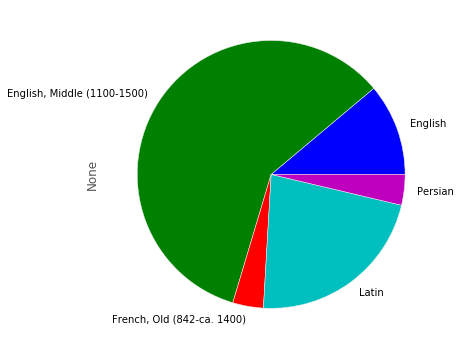

In [74]:
t.showPie()
# TODO: make colors prettier